In [21]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [22]:
def load_numpy(hold_position):
    file_path = "../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_lacc_norm_spectram.npy"
    x = np.load(file_path)
    return x

In [23]:
Bag = load_numpy("Bag")
Hips = load_numpy("Hips")
Torso = load_numpy("Torso")
Hand = load_numpy("Hand")

Bag.shape

(195491, 33, 1)

In [24]:
X_train = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
X_train.shape

(781964, 33, 1)

In [25]:
Y_train = np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_Label.npy")[:, 0, 0].reshape([-1, 1])
Y_train = np.concatenate([Y_train, Y_train, Y_train, Y_train], axis=0)
Y_train.shape

(781964, 1)

In [26]:
def load_numpy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_lacc_norm_spectram.npy"
    x = np.load(file_path)
    return x

In [27]:
Bag = load_numpy("Bag")
Hips = load_numpy("Hips")
Torso = load_numpy("Torso")
Hand = load_numpy("Hand")

Bag.shape

(28685, 33, 1)

In [28]:
X_test = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
X_test.shape

(114740, 33, 1)

In [29]:
Y_test = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
Y_test = np.concatenate([Y_test, Y_test, Y_test, Y_test], axis=0)
Y_test.shape

(114740, 1)

In [30]:
Y_train[Y_train >= 5] = 1
Y_test[Y_test >= 5] = 1

In [31]:
X_train = X_train.reshape([-1, 33])
X_test = X_test.reshape([-1, 33])

In [31]:
# 標準化
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)
# X_train = X_train[:, 1:]
# X_test = X_test[:, 1:]
X_train.shape, X_test.shape

((781964, 33), (114740, 33))

In [32]:
X_train = X_train[:, feature_index]
X_test = X_test[:, feature_index]
X_train.shape, X_test.shape

((781964, 7), (114740, 7))

In [33]:
model = xgb.XGBClassifier(max_depth=3, min_child_weight=1, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [34]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

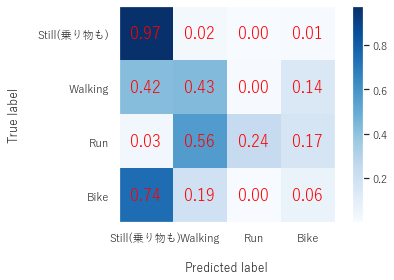

In [35]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']
predict = model.predict(X_test)
plot_confusion_matrix(Y_test, predict, class_names, True)
plt.grid(False)

0.4911814331570536
0.5260915565791762
0.48622528300493234
0.3537364292715425


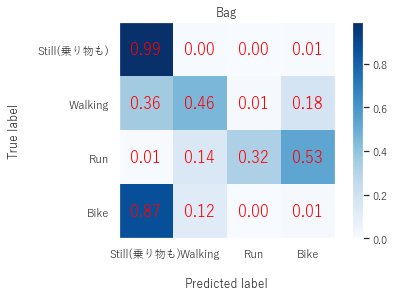

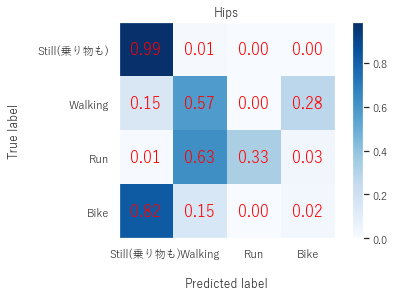

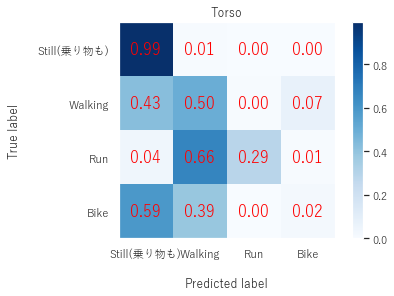

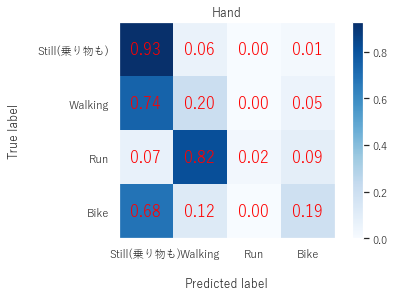

In [36]:
from sklearn.metrics import f1_score
validation_size = X_test.shape[0] // 4
hold_positions = ["Bag", "Hips", "Torso", "Hand"]
for i in range(4):
    plot_confusion_matrix(Y_test[validation_size*i:validation_size*(i+1)], predict[validation_size*i:validation_size*(i+1)], class_names, True)
    print(f1_score(Y_test[validation_size*i:validation_size*(i+1)], predict[validation_size*i:validation_size*(i+1)], average='macro'))
    plt.title(hold_positions[i])
    plt.grid(False)

In [37]:
f1_macro = f1_score(Y_test, predict, average='macro')
f1_macro

0.4702487590481293

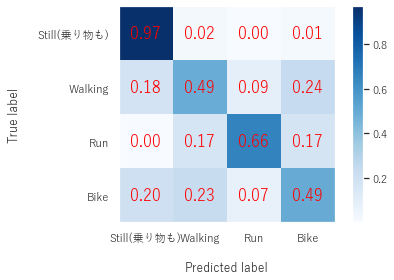

In [38]:
predict = model.predict(X_train)
plot_confusion_matrix(Y_train, predict, class_names, True)
plt.grid(False)

In [39]:
f1_macro = f1_score(Y_train, predict, average='macro')
f1_macro

0.6547655022317045

In [20]:
feature_index = np.argsort(-model.feature_importances_)[-8:-1]

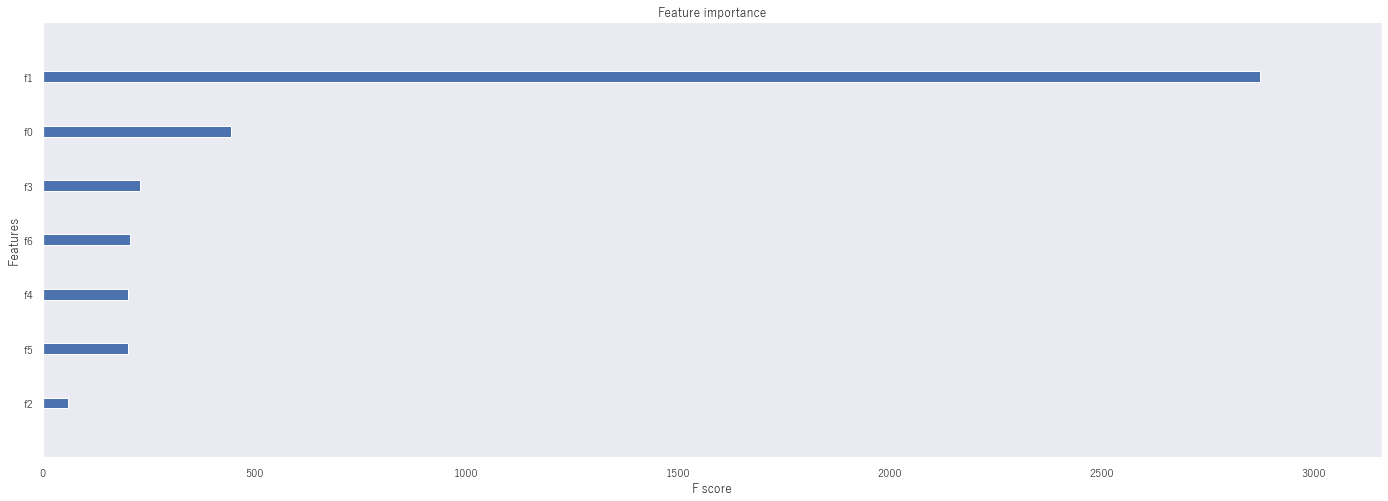

In [40]:
_, ax = plt.subplots(figsize=(24, 8))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)
plt.grid(False)

In [106]:
Y_train = Y_train[~np.isnan(X_train)[:, 0]].reshape([-1, 1])
X_train = X_train[~np.isnan(X_train)[:, 0], :]
X_train.shape, Y_train.shape

((781963, 33), (781963, 1))

In [90]:
# MinMaxScaler
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

In [112]:
# StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [113]:
np.sum(np.isnan(X_test))

0

In [42]:
(Y_train[:, 0]==1)

array([False, False, False, ...,  True,  True,  True])

C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Owner\Anaconda3\envs\GPU\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


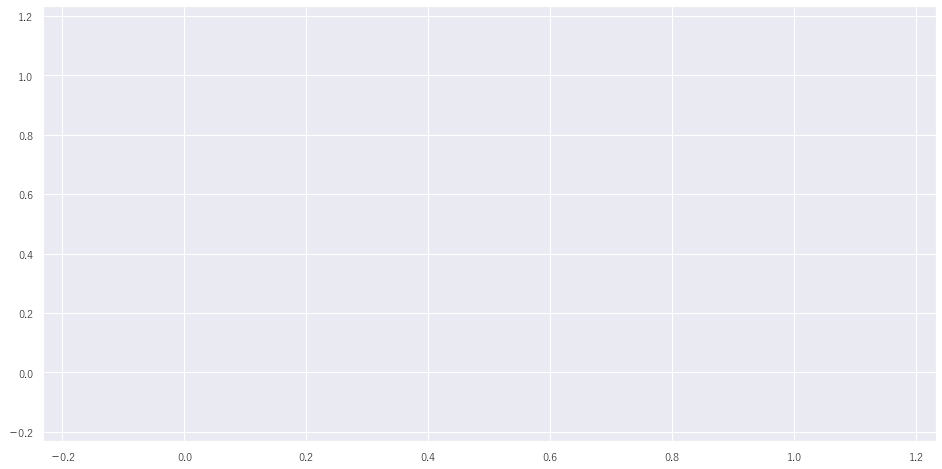

In [116]:
plt.figure(figsize=(16, 8))
sns.distplot(X_train[(Y_train[:, 0]==1)[0], 5], label='train_bike')
sns.distplot(X_test[(Y_test[:, 0]==1)[0], 5], label='val_bike')


In [115]:
X_train[(Y_train[:, 0]==4)[0], 5].mean()

-0.1386528715597612